In [79]:
#importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
ps=PorterStemmer()
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
from keras.models import Sequential
from keras.layers import LSTM,Dense
from keras.preprocessing import sequence
from keras.layers.embeddings import Embedding

In [80]:
#reding the data set
ds=pd.read_csv('D:\\dataset\\amazon_reviews\\Reviews.csv')
print(ds.shape)

(568454, 10)


In [81]:
#now we are removing the duplicate rows
ds.drop_duplicates(subset={'UserId','ProfileName','Time','Text'},keep='first',inplace=True)
#print(ds.head())
print(ds['Score'].value_counts())
print(ds.shape)

5    250962
4     56094
1     36306
3     29769
2     20802
Name: Score, dtype: int64
(393933, 10)


In [82]:
#now we are removing the rows where score ==3 because we don't know that we have take positive or negative
final_ds=ds.loc[ds['Score'] != 3]
print(final_ds['Score'][:5])
print("total number of duplicates row are: ",len(ds)-len(final_ds))
#now we don't need Id
print(final_ds.shape)

0    5
1    1
2    4
3    2
4    5
Name: Score, dtype: int64
total number of duplicates row are:  29769
(364164, 10)


In [83]:
#now we are converting the reating into binary form
def partition(x):
    if(x<3):
        return 'Negative'
    else:
        return "Positive"
actual_score=final_ds['Score']
positiveNegative=actual_score.map(partition)
final_ds['Score']=positiveNegative
print(final_ds['Score'].value_counts())

Positive    307056
Negative     57108
Name: Score, dtype: int64


C:\Users\mohda\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [84]:
#droping the id column because there is use of that
final_ds.drop(columns='Id',inplace=True)
final_ds.head()

C:\Users\mohda\Anaconda3\envs\tensorflow\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [85]:
#checking the maximum length of text
ans=0
for text in final_ds['Text']:
    if(len(text)>ans):
        ans=len(text)
print(ans)

16952


In [86]:
#checking the null value
final_ds.isnull().sum()

ProductId                  0
UserId                     0
ProfileName               11
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                    1
Text                       0
dtype: int64

In [91]:
#droping the null values row
final_ds=final_ds.dropna()
final_ds.reset_index(drop=True,inplace=True)
final_ds['Text'][29]

"I have never been a huge coffee fan. However, my mother purchased this little machine and talked me into trying the Latte Macciato. No Coffee Shop has a better one and I like most of the other products, too (as a usually non-coffee drinker!).<br />The little Dolche Guesto Machine is super easy to use and prepares a really good Coffee/Latte/Cappuccino/etc in less than a minute (if water is heated up). I would recommend the Dolce Gusto to anyone. Too good for the price and I'am getting one myself! :)"

In [92]:
#for making the model i have consider only for 1 row this model can also for same column
X=final_ds['Text'][:50000]
y=final_ds['Score'][:50000]

In [93]:
import time
s=time.time()
print(type(X))
for i in range(len(X)):
    temp=re.sub('[^[a-zA-Z]',' ',X[i])
    temp=temp.lower()
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    temp = pattern.sub('', temp)
    temp=temp.split()
    #temp=[word for word in temp if temp not in stopwords.words('english')]
    X[i]=" ".join(temp)
print('total time taken :',time.time()-s)
print(X[0])

<class 'pandas.core.series.Series'>
total time taken : 20.102236032485962
bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better


In [94]:
#calculation the frequency of each word 
frequency={}
for i in range(len(X)):
    for word in X[i].split():
        try:
            frequency[word]+=1
        except:
            frequency[word]=1

In [95]:
#sorting the frequency with respect to occurance of letter
frequency={k:v for k ,v in sorted(frequency.items(),key=lambda item : item[1],reverse=True)}

In [96]:
#giving the ranking accoring to the frequency
f={} ; i=1
for k,v in frequency.items():
    f[k]=i
    i+=1

In [97]:
#converting the data into numerical form using rank of frequency of words
text=[]
for i in range(len(X)):
    temp=[]
    for word in X[i].split():
        temp.append(f[word])
    text.append(temp)
text=np.array(text)

In [106]:
#converting the y into bianry form
y=[1 if i=='Positive' else 0 for i in y]
y=np.array(y)

In [107]:
#spliting the data into train and test
split=int(len(text)*.8)
train_x=text[:split] ; train_y=y[:split]
test_x=text[split:] ; test_y=y[split:]
print(len(train_x),len(train_y))

40000 40000


In [108]:
#choosing only top 5000 words
top_words=5000
for i in range(len(train_x)):
    temp=[]
    for j in train_x[i]:
        if(j<=5000):
            temp.append(j)
    train_x[i]=temp
for i in range(len(test_x)):
    temp=[]
    for j in test_x[i]:
        if(j<=5000):
            temp.append(j)
    test_x[i]=temp

In [109]:
#doing padding for making the batch
max_length_review=600
train_x=sequence.pad_sequences(train_x,maxlen=max_length_review)
test_x=sequence.pad_sequences(test_x,maxlen=max_length_review)

In [110]:
#building the model for training the data
embedding_vector_length=32
model=Sequential()
model.add(Embedding(top_words,embedding_vector_length,input_length=600))
model.add(LSTM(100))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 600, 32)           160000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________


In [111]:
#training the model for input data
history=model.fit(train_x,train_y,nb_epoch=10,batch_size=64,verbose=1,validation_data=(test_x,test_y))

C:\Users\mohda\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  
C:\Users\mohda\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 371s 9ms/step - loss: 0.0100 - accuracy: 0.9992 - val_loss: 1.0902e-05 - val_accuracy: 1.0000
Epoch 2/10
40000/40000 [==============================] - 373s 9ms/step - loss: 6.9396e-06 - accuracy: 1.0000 - val_loss: 4.4866e-06 - val_accuracy: 1.0000
Epoch 3/10
40000/40000 [==============================] - 370s 9ms/step - loss: 3.3428e-06 - accuracy: 1.0000 - val_loss: 2.4867e-06 - val_accuracy: 1.0000
Epoch 4/10
40000/40000 [==============================] - 369s 9ms/step - loss: 1.9710e-06 - accuracy: 1.0000 - val_loss: 1.5539e-06 - val_accuracy: 1.0000
Epoch 5/10
40000/40000 [==============================] - 370s 9ms/step - loss: 1.2714e-06 - accuracy: 1.0000 - val_loss: 1.0334e-06 - val_accuracy: 1.0000
Epoch 6/10
40000/40000 [==============================] - 371s 9ms/step - loss: 8.6138e-07 - accuracy: 1.0000 - val_loss: 7.1282e-07 - val_accuracy: 1.0000
Epoch 7/10
40000/4

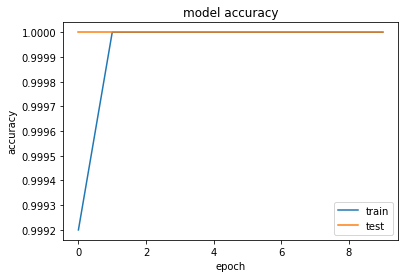

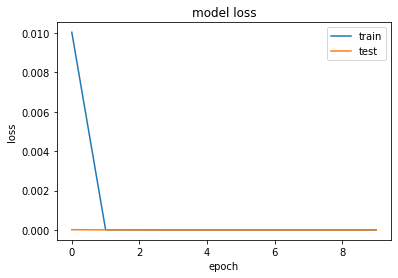

In [113]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()